# Extract Text from Image With Tesseract
This notebook explores the use of computer vision to read screenshots from air handling unit (AHU) building automation system (BAS) interfaces, extracting text data using `tesseract`. It includes experimentation with various CV processing techniques aimed at improving text extraction processes. Additionally, text reordering in `Pandas` is explored to enhance its relevance for a language model (LLM), helping to understand the operational status of the AHU based on extracted data.

pip install pytesseract Pillow opencv-python matplotlib pandas ipython scipy

Tested on Windows inside VS code notebooks. Download latest version of `tesseract` which I installed the prebuilt .exe from here:
* https://github.com/UB-Mannheim/tesseract/wiki

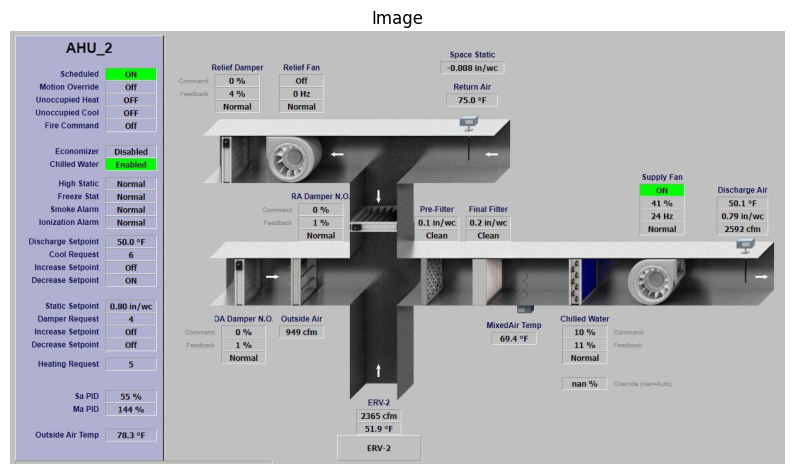

In [1]:
import matplotlib.pyplot as plt
import cv2


ahu = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu\ahu.jpg'
ahu_copy_1 = ahu # grayscale and binary thresholding
ahu_copy_2 = ahu # grayscale and binary thresholding and sorting text results with Pandas


# Function to display the image
def display_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Read the image using OpenCV
image = cv2.imread(ahu)

display_image(image)


# The human engineer or Cx review of how the AHU is operating

The AHU is currently operating in cooling mode with minimal outside air supplied by an energy recovery unit (ERV), maintaining a discharge air temperature setpoint of 50°F and a supply duct static pressure setpoint of 0.8" WC. The supply fan is modulating at 41% speed to achieve 0.79" WC of duct static pressure, with the supply air temperature measured at 50.1°F. Airflow stations indicate 949 CFM of outside air and 2365 CFM at 51.9°F from the ERV, alongside a return air temperature of 75°F. Relief fans are inactive, and a slightly negative space static pressure suggests a possible negative pressure build-up, if accurate. Airflow measurements from the ERV and supply fan indicate minimal to no return air volume, prompting consideration of whether the AHU is designed for the ERV to exclusively handle return air in non-economizer mode. Feedback indicates effective operation without mechanical faults.

Overall, the AHU appears to be performing well. It may be beneficial to implement resets for temperature and duct static pressure setpoints to enhance energy savings. Additionally, the necessity of the 50°F supply temperature setpoint could be evaluated further. Typically, systems are designed with a 55°F temperature setpoint for cooling or dehumidification modes, suggesting that the lower setting may require investigation into potential design overrides or adjustments.

# Ask ChatGPT-4o to analyze computer vision with prompt template
```
The following data is extracted with computer vision from a BAS graphic of a VAV AHU. Please provide feedback to the human building operator in the following format:

The AHU is currently operating in [mode of operation: heating, or cooling] with [details about outside air temperature conditions if applicable to indicate load on the system or building], and maintaining [specific setpoints or operational parameters for supply duct static pressure or temperature]. The supply fan is [operating at % speed command], achieving [achieved duct static pressure], with the supply air temperature measured at [temperature if applicable]. Relief or return air fans are [status if applicable to this type of HVAC system], and [additional details about system operation]. Airflow measurements from [specific components if system has air flow measuring stations] indicate [observations about airflow direction or volume]. Feedback indicates [assessment of system operation, e.g., effectiveness or issues].

Overall, the AHU appears to be [general assessment of performance and detection of faults like broken valves or dampers for energy inefficiency or sensor errors]. It may be beneficial to [recommendation for improvement, e.g., operational adjustments or maintenance]. Additionally, [consideration of specific operational parameters or setpoints] could be evaluated further especially anything related to ventilation requirements for commercial building and energy efficiency.
```

In [2]:
import pytesseract
from PIL import Image
import numpy as np
from IPython.display import display, HTML

# Specify the path to tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\bbartling\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'


In [3]:
# Function to extract text from an image
def image_to_text(image_path):
    image = cv2.imread(image_path)
    text = pytesseract.image_to_string(image)
    return text

# Extract text from the image
extracted_text_ahu = image_to_text(ahu)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


# Chat GPT 4o response:

The AHU is currently operating in cooling mode with an outside air temperature of 50.0 °F, indicating that there may be a lower load on the system due to cooler external conditions. The system is maintaining a discharge air temperature setpoint of 50.1 °F and a static pressure setpoint of 0.80 in/wg.

The supply fan is operating at 41% speed command, achieving a duct static pressure of 0.79 in/wg, with the supply air temperature measured at 50.1 °F. The relief or return air fans are operating normally with a static pressure of 0.008 in/wg and a return air temperature of 75.0 °F. The airflow measurements from the system indicate a supply airflow of 2592 cfm, with outside air dampers at 0% and chilled water flow at 10%.

Feedback indicates that the AHU appears to be operating effectively, but there are a few observations and recommendations:

1. **Airflow and Temperature Consistency**: The mixed air temperature is 69.4 °F, and the return air temperature is 75.0 °F. There is a significant difference between these temperatures, suggesting potential inefficiencies or areas for investigation in the mixing process.

2. **Damper Position**: The outside air damper is at 0%, which is appropriate given the low outside air temperature. However, this should be periodically checked to ensure proper operation and modulation.

3. **Fan Speeds and Static Pressure**: The supply fan is at 41% speed while maintaining the desired static pressure. This suggests the system is operating efficiently, but it is always beneficial to periodically review the static pressure setpoint and fan speed to ensure optimal energy use.

Overall, the AHU appears to be performing well without immediate signs of faults like broken valves or dampers. It may be beneficial to periodically check the mixing process and damper operations to ensure energy efficiency and optimal performance. Additionally, evaluating ventilation requirements and ensuring that the system meets commercial building standards for air quality and energy efficiency is advisable.

# Further CV preproccessing

Mild Preprocessing Approach
* Grayscale Conversion: Convert the image to grayscale to reduce complexity.
* Mild Resizing: Upscale the image slightly to help with small text.
* Simple Thresholding: Apply binary thresholding to make the text stand out without excessive blurring.

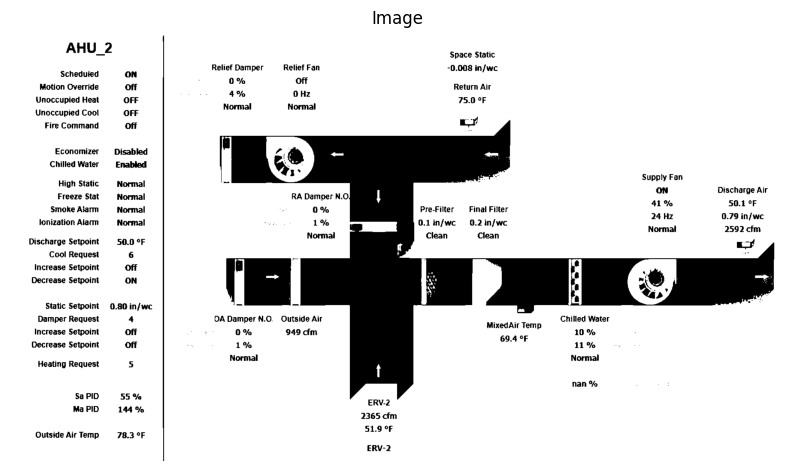

In [4]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Mild upscaling of the image
    scale_percent = 150  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh


# Preprocess and display the image
preprocessed_image = preprocess_image(ahu_copy_1)
display_image(preprocessed_image)

# Extract text from the image
extracted_text_ahu = image_to_text(ahu_copy_1)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


# Chat GPT 4o response:

The AHU is currently operating in cooling mode with an outside air temperature of 50.0°F, indicating that the load on the system is relatively low. The unit is maintaining a supply duct static pressure setpoint of 0.80 in/wc. The supply fan is operating at 41% speed command, achieving a duct static pressure of 0.79 in/wc, with the supply air temperature measured at 50.1°F. 

Relief or return air fans are operating normally, with the relief damper at 4% open and the return air at 2592 cfm. Airflow measurements from the outside air damper indicate 949 cfm, and from the mixed air damper, 2365 cfm, showing normal operation. 

Feedback indicates that the system is operating effectively, with all key components functioning as expected. The outside air damper is at 0% open, the chilled water valve is at 10%, and the mixed air temperature is 69.4°F.

Overall, the AHU appears to be performing well, with no detected faults such as broken valves or dampers causing energy inefficiency or sensor errors. It may be beneficial to monitor the chilled water valve's percentage to ensure optimal cooling efficiency. Additionally, evaluating the static setpoint for potential adjustments could further improve system performance.

AHU_: 
- Scheduled: Off
- Motion Override: Off
- Unoccupied Heat: Off
- Unoccupied Cool: Off
- Fire Command: Disabled
- Economizer: Normal
- Chilled Water: Normal
- High Static: Normal
- Freeze Stat: Normal
- Smoke Alarm: Normal
- Ionization Alarm: Normal
- Discharge Setpoint: 50.0°F
- Cool Request: 55%
- Static Setpoint: 0.80 in/wc
- Heating Request: Off
- Outside Air Temp: 50.0°F
- Supply Fan: 41% speed, 50.1°F, 0.79 in/wc, 2592 cfm
- Relief Damper: 4%
- Return Air: Normal
- Final Filter: 0.2 in/wc (Clean)
- Outside Air Damper: 0%
- Mixed Air Temp: 69.4°F, 2365 cfm

# See if we can get better results by organizing the text data by coordinates recorded during the CV processes

 Tesseract OCR and OpenCV to extract text from an HVAC Building Automation System (BAS) graphic, annotate the detected text, and display the results. The process involves the following steps:

1. **Image Preprocessing**:
   - The image is read and resized to enhance the text detection process.
   - It is then converted to grayscale and binary thresholding is applied to highlight the text.

2. **Text and Coordinate Extraction**:
   - Tesseract OCR is used to extract text and their corresponding coordinates (bounding boxes) from the preprocessed image.
   - The extracted text data includes confidence scores, which are filtered to retain high-confidence results.

3. **Displaying Annotated Image**:
   - The image is annotated with rectangles and text labels indicating the position and content of the detected text.
   - This annotated image is displayed for visual verification.

4. **Displaying Thresholded Image**:
   - The thresholded image used for text detection is displayed to understand the preprocessing effect.

5. **Structured Display of Extracted Text**:
   - The extracted text along with their coordinates is displayed in a scrollable HTML format for easy review.
   - The text data is sorted by coordinates to help identify related components (e.g., sensor names and their values) and presented in a pandas DataFrame for clear and organized analysis.

6. Try optimize the sorting of the pandas DataFrame to reflect how the data appears on the BAS graphic
   - The group_text_elements function groups text elements that are close together vertically, within a specified threshold.
   - The sort_within_groups function sorts the text elements within each group by their x and y coordinates. This method should help in organizing the text elements to better reflect their layout on the BAS graphic. You can adjust the threshold value in group_text_elements to fine-tune the grouping based on your specific needs.

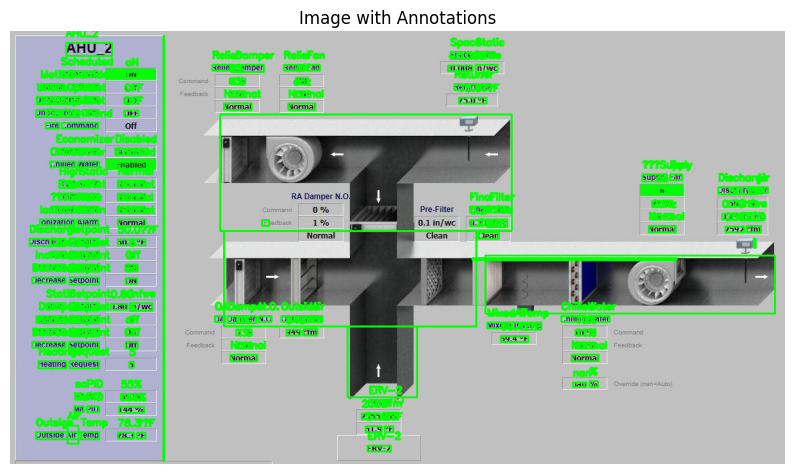

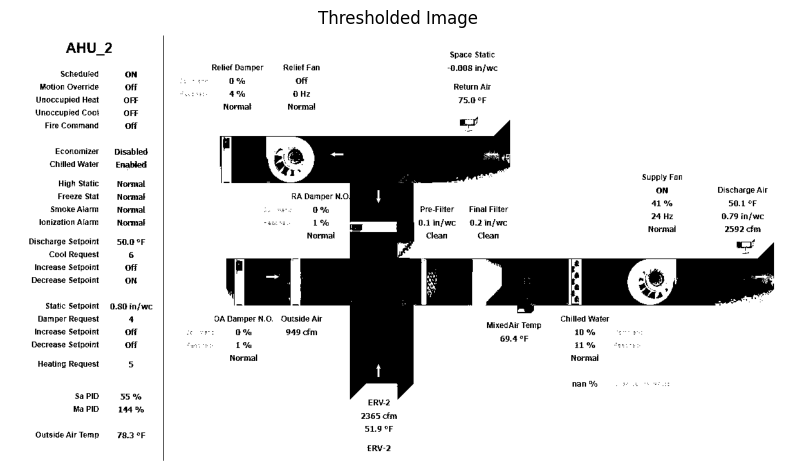

Text,Coordinates
AHU_2,"(87, 18, 71, 20)"
Scheduted,"(79, 62, 58, 9)"
Motion,"(47, 82, 37, 9)"
Override,"(89, 82, 49, 9)"
Unoccupied,"(41, 102, 67, 11)"
Heat,"(113, 102, 25, 9)"
Uncccupied,"(40, 122, 67, 11)"
Coot,"(112, 122, 26, 9)"
Fire,"(55, 142, 21, 9)"
Command,"(80, 142, 57, 9)"


In [5]:
import pandas as pd

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))
    
    return text_with_coords, original_image, preprocessed_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()

# Function to display the thresholded image
def display_thresholded_image(thresh_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(thresh_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

# Group text elements by proximity
def group_text_elements(text_with_coords, threshold=50):
    groups = []
    current_group = [text_with_coords[0]]
    
    for text, coords in text_with_coords[1:]:
        last_coords = current_group[-1][1]
        if abs(coords[1] - last_coords[1]) <= threshold:
            current_group.append((text, coords))
        else:
            groups.append(current_group)
            current_group = [(text, coords)]
    groups.append(current_group)
    return groups

# Sort text elements within each group
def sort_within_groups(groups):
    sorted_text_with_coords = []
    for group in groups:
        group.sort(key=lambda x: (x[1][1], x[1][0]))
        sorted_text_with_coords.extend(group)
    return sorted_text_with_coords

# Function to form a sentence from text elements
def form_sentence_from_text(text_with_coords):
    sentence = " ".join([text for text, _ in text_with_coords])
    return sentence

extracted_text_with_coords, original_image, thresh_image = image_to_text_with_coordinates(ahu_copy_2)

# Group and sort text elements
groups = group_text_elements(extracted_text_with_coords)
sorted_text_with_coords = sort_within_groups(groups)

# Display the image with annotated text
display_image_with_annotations(original_image, sorted_text_with_coords)

# Display the thresholded image
display_thresholded_image(thresh_image)

# Convert the DataFrame to an HTML table and display it in a scrollable div
df = pd.DataFrame(sorted_text_with_coords, columns=["Text", "Coordinates"])
html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))

# Form and print a sentence from the text elements
sentence = form_sentence_from_text(sorted_text_with_coords)




In [6]:
print("FEED SENTANCE INTO CHATGPT")

sentence

FEED SENTANCE INTO CHATGPT


'AHU_2 Scheduted Motion Override Unoccupied Heat Uncccupied Coot Fire Command Economizer Chilled Water High Static Freeze Stat ‘Smoke Alam lonization Alarm Discharge Setpoint Cool Request Increase Setpoint Decrease Setpoint Static Setpoint Damper Request Increase Setpoint Decrease Setpoint Heating Request sa PID Ma PID Air Outsige Temp oN OFF OFF Disabled Enabled Normal Normat Normal Normat 50.0°F 6 Off on infwe 0.80 4 off Off 5 55% 144% 78.3 °F   Relief Damper 0% 4% Normat             OA Damper N.O. Outside Air 0% 1% Normal Relief Fan off onz Normal cfm 949 ERV-2 cfm 2365 51.9 °F ERV-2   Space Static infwe -0.008 Return Air 75.0°F Final Filter infwe 0.2 Clean ‘Supply Fan on AL% 2a Hz Normal   Chilled Water MixedAir Temp 10% 69.4°F 11% Normal % nan Discharge Air 50.1 °F infwe 0.79 cfm 2592   '

# Chat GPT 4o response:
The AHU is currently operating in cooling mode with an outside air temperature of 50.0°F, indicating a moderate load on the system. The AHU is maintaining the following specific setpoints and operational parameters:

- Supply fan is operating at 78.3% speed command, achieving a duct static pressure of 0.79 inches of water column.
- Supply air temperature is measured at 50.1°F.
- Relief fan is off, and the relief damper is at 0% open, while the outside air damper is 1% open, showing normal operation.
- The economizer is disabled.
- Chilled water valve is at 10% open, and the mixed air temperature is 69.4°F.
- Return air temperature is 75.0°F.
- Space static pressure is -0.008 inches of water column.
- Airflow measurements indicate the following:
  - Supply airflow is 2592 CFM.
  - ERV-2 supply airflow is 2365 CFM.
  - ERV-2 outside air temperature is 51.9°F.

Feedback indicates normal system operation with no apparent faults. The chilled water valve and mixed air temperatures suggest that the system is adequately cooling the space.

Overall, the AHU appears to be performing well without any obvious issues such as broken valves or dampers. It may be beneficial to continue monitoring the economizer operation and ensure it is enabled when outside conditions permit to improve energy efficiency. Additionally, evaluating specific operational parameters or setpoints related to ventilation requirements for the commercial building and energy efficiency could be valuable.